# Лабораторная работа №4. Синтез КИХ-фильтров.
Курс: лаборатория цифровой обработки сигналов, ФРКТ МФТИ
#  Модуль 1. Метод частотной выборки.

## План занятий лабораторной работы №4
* **Mетод частотной выборки (Frequency Sampling Method)** — *занятие 1 модуль 1*.
* Метод окон (window method) — *занятие 2 модуль 2*.
* Оптимальные методы — *занятие 3 модуль 3*.
* * Наименьших квадратов (least-squares error minimization).
* * Равномерной Чебышёвской аппроксимации (minimax method, Parks–McClellan filter design algorithm, Remez algorithm).
* Фильтрация АМ-сигнала, полученного с помощью цифрового осциллографа — *занятие 4 модуль 4*.

In [1]:
%matplotlib inline

# %matplotlib notebook

# %matplotlib widget

# Установка widget
#!pip install --upgrade jupyterlab ipympl


In [2]:
# Импорт библиотек
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import matplotlib.ticker as ticker


## Основные сведения о КИХ-фильтрах 

КИХ — конечная импульсная характеристика.

У КИХ-фильтров импульсная характеристика $h[k]$ представлена конечным набором ненулевых отсчетов $h[0]$, $h[1]$, $\dots$, $h[N-1]$. Передаточная функция $H(z)$ представлена конечным числом слагаемых. 


$H\left( z \right)={{h}[0]}+{{h}[1]}{{z}^{-1}}+...+{{h}[{N-1}]}{{z}^{-\left( N-1 \right)}}=\sum\limits_{k=0}^{N-1}{h[k]{{z}^{-k}}}$

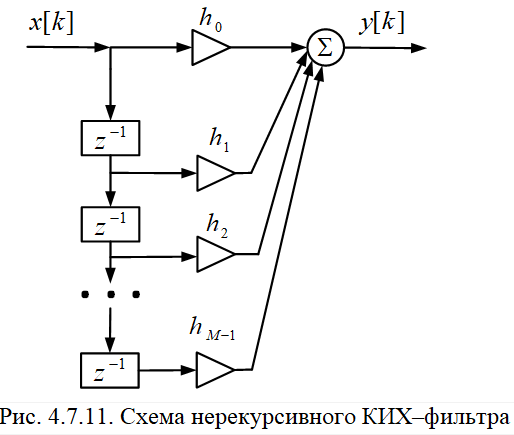

### Порядок фильтра
* $N$ - число ненулевых отсчетов импульсной характеристики 
* $R=N-1$ - порядок фильтра (число блоков задержки на один такт $z^{-1}$) в нерекурсивной реализации

### Разностное уравнение нерекурсивной реализации
$$y[k]=\sum\limits_{m\,=\,0}^{N-1}{{h}_{m}}\,x[k-m].$$

### Устойчивость
* КИХ-фильтры всегда устойчивы, поскольку выполняется $\sum_k |h[k]|<\infty$.
* В рекурсивной реализации функция $H(z)$ может иметь полюса на единичной окружности, однако они будут скомпенсированы нулями этой функции.

### Виды КИХ-фильтров с кусочно-линейной ФЧХ

Классификация  $h[k]$ на $[0, N-1]$

| $h[k]$ |  $N$ - нечетное |  $N$ - четное   |  
|:--------------------:|----:|-----:|
|   симметрична   | 1 тип | 2 тип |
|  антисимметрична  | 3 тип | 4 тип |


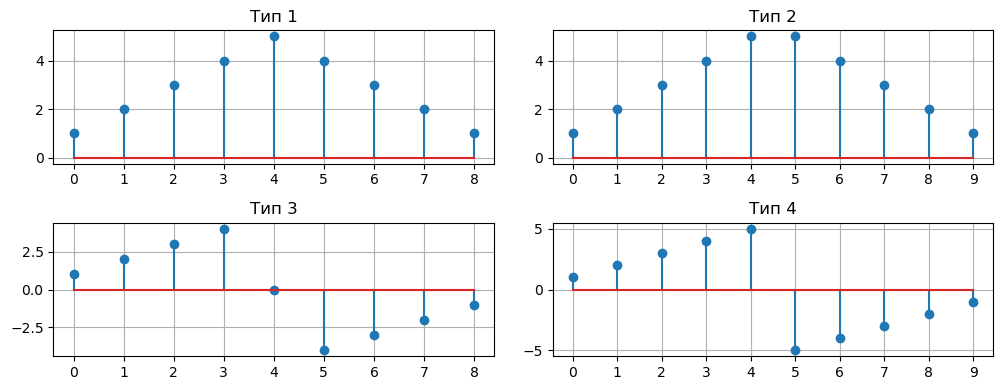

In [3]:
h_set = {1: np.array([1, 2, 3, 4, 5, 4, 3, 2, 1]),
         2: np.array([1, 2, 3, 4, 5, 5, 4, 3, 2, 1]),
         3: np.array([1, 2, 3, 4, 0, -4, -3, -2, -1]),
         4: np.array([1, 2, 3, 4, 5, -5, -4, -3, -2, -1])}
plt.figure(figsize=[10, 4])
for fir_type in [1, 2, 3, 4]:
    h=h_set[fir_type]
    ax = plt.subplot(2, 2, fir_type)
    plt.stem(np.arange(len(h)), h)
    plt.title("Тип %i" % fir_type)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
    plt.grid()
plt.tight_layout()  


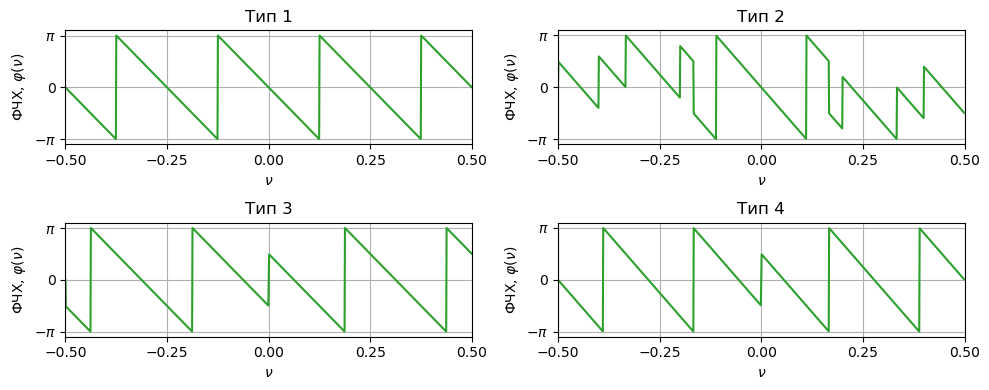

In [4]:
M=1024
plt.figure(figsize=[10, 4])
for fir_type in [1, 2, 3, 4]:
    h=h_set[fir_type]
    ax = plt.subplot(2, 2, fir_type)
    H1=np.fft.fftshift((np.fft.fft(h, M)))
    plt.plot(np.arange(M)/M-0.5, np.angle(H1), color='C2')
    plt.title("Тип %i" % fir_type)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.25))
    plt.xlim([-0.5, 0.5])
    plt.yticks([-np.pi, 0, np.pi], labels=("$-\pi$", "0", "$\pi$"))
    plt.xlabel('$\\nu$')
    plt.ylabel('ФЧХ, $\\varphi(\\nu)$')
    plt.grid()
plt.tight_layout() 


### Групповая и фазовая задержки фильтра

Фазовая задержка фильтра – это величина временной задержки, которую испытывает каждый частотный компонент сигнала при прохождении через фильтр: 
$${{\tau }_{\text{ф}}}=- \frac{\varphi (\omega )}{\omega }= -\frac{\varphi (\theta )}{\theta } \Delta t.$$

Групповая задержка – средняя временная задержка составного сигнала:
$${{\tau }_{\text{гр}}}= - \frac{d\varphi (\omega )}{d\omega }= - \frac{d\varphi (\theta )}{d\theta } \Delta t.$$

Величина групповой задержки для фильтров 1-4 типов с кусочно линейной ФЧХ $\tau_\text{гр} =\dfrac{N-1}{2} \Delta t$  и постоянна для всех частот (точки разрыва фазы не рассматриваем). 

`signal.group_delay` [https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.group_delay.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.group_delay.html)

*Parameters:*

`w, gd = scipy.signal.group_delay(system, w=512, whole=False, fs=6.283185307179586)`
* `system` tuple of array_like (beta, alpha)
* `w` {None, int, array_like}, optional
** If a single integer, then compute at that many frequencies (default is N=512).
** If an array_like, compute the delay at the frequencies given. These are in the same units as fs.

* `fs` float, optional
The sampling frequency of the digital system. Defaults to 2*pi radians/sample.

*Returns:*
* `w` ndarray The frequencies at which group delay was computed, in the same units as fs. By default, w is normalized to the range [0, pi) (radians/sample).
* `gd` ndarray The group delay. (в числе тактов дискретизации).  

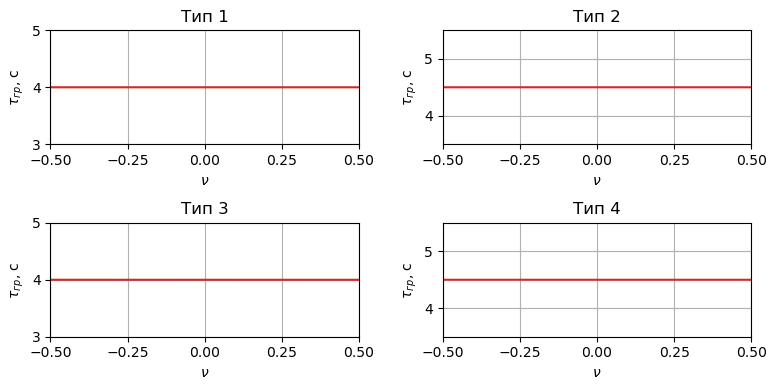

In [5]:
delta=1e-4
fs=1
plt.figure(figsize=[8, 4])
for fir_type in [1, 2, 3, 4]:
    h=h_set[fir_type]
    nu, gd = signal.group_delay((h, [1]), w=np.linspace(-0.5+delta, 0.5-delta, num=2048), fs=fs)
    ax = plt.subplot(2, 2, fir_type)
    gd_seconds=gd/fs
    plt.plot(nu, gd_seconds, 'C3')
    plt.ylabel('$\\tau_{{гр}}$, c')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.25))
    plt.xlim([-0.5, 0.5])
    plt.ylim([min(gd_seconds)-1, max(gd_seconds)+1])
    plt.xlabel('$\\nu$')
    plt.title("Тип %i" % fir_type)
    plt.grid()
plt.tight_layout()  


### Пример. CIC-фильтр

$$ H\left( z \right)=\sum\limits_{m\,=\,0}^{N-1}{{{h}_{m}}}{{z}^{-m}}=1+{{z}^{-1}}+{{z}^{-2}}+.\text{ }\text{. }\text{. }{{z}^{-(N-1)}}=\frac{1-{{z}^{-N}}}{1-{{z}^{-1}}}.$$

beta =  [1 1 1 1 1 1 1 1 1 1]
alpha =  [1 0 0 0 0 0 0 0 0 0]


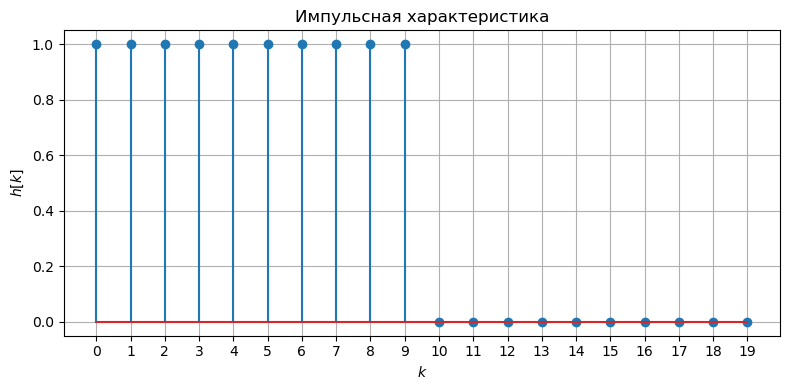

In [6]:
# нерекурсивная реализация
N=10
beta = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
alpha = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
print('beta = ', beta)
print('alpha = ', alpha)
dt=1
t, y = signal.dimpulse(system=(beta, alpha, dt), n=20)
y=np.squeeze(y)
plt.figure(figsize=[8, 4])
ax = plt.axes()
plt.stem(t, y)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
plt.xlabel('$k$')
plt.ylabel('$h[k]$')
plt.title("Импульсная характеристика")
plt.tight_layout()
plt.grid()


beta =  [ 1  0  0  0  0  0  0  0  0  0 -1]
alpha =  [ 1 -1  0  0  0  0  0  0  0  0  0]


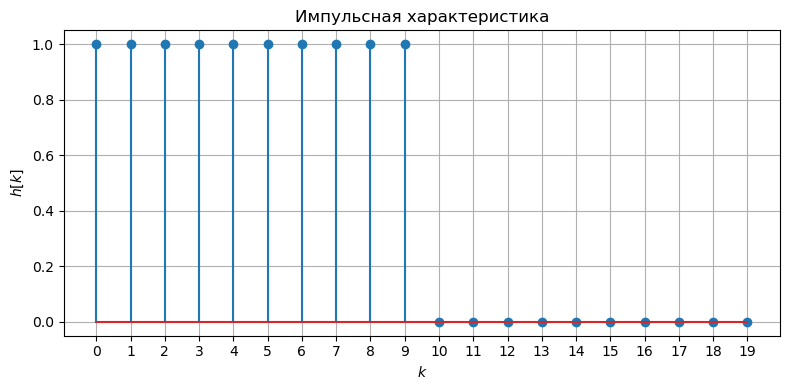

In [7]:
# рекурсивная реализация
N=10
beta = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1])
alpha = np.array([1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
print('beta = ', beta)
print('alpha = ', alpha)
dt=1
t, y = signal.dimpulse(system=(beta, alpha, dt), n=20)
y=np.squeeze(y)
plt.figure(figsize=[8, 4])
ax = plt.axes()
plt.stem(t, y)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
plt.xlabel('$k$')
plt.ylabel('$h[k]$')
plt.title("Импульсная характеристика")
plt.tight_layout()
plt.grid()


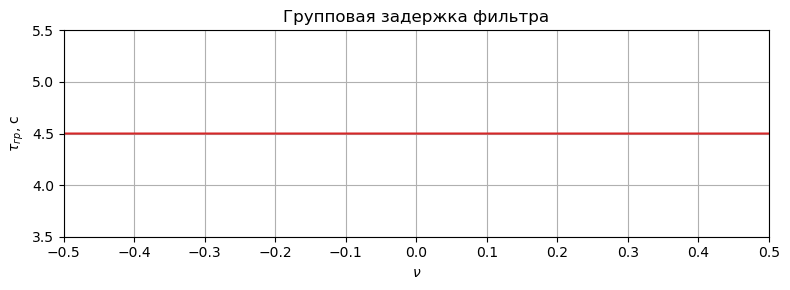

In [8]:
delta=1e-6
fs=1
nu, gd = signal.group_delay((beta, alpha), w=np.linspace(-0.5+delta, 0.5-delta, num=2048), fs=fs)
plt.figure(figsize=[8, 3])
ax = plt.axes()
plt.title('Групповая задержка фильтра')
gd_seconds=gd/fs
plt.plot(nu, gd_seconds, 'C3')
plt.ylabel('$\\tau_{{гр}}$, c')
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
plt.xlim([-0.5, 0.5])
plt.ylim([min(gd_seconds)-1, max(gd_seconds)+1])
plt.xlabel('$\\nu$')

plt.grid()
plt.tight_layout()


## Mетод частотной выборки синтеза КИХ-фильтров

Метод основан на взятии выборок $f_n=f_д \dfrac{n}{N}$ частотной характеристики фильтра $H(\nu)$. Путь далее $N$ - нечетное. По этим выборкам находится обратное ДПФ, которое будет представлять собой периодическую последовательность.  Необходимо выбрать один период этой последовательности. Рассмотрим различные варианты.


In [9]:
def ideal_lowpass2(f, f_c=450, fs=2000):
    f1=450
    f2=550
    if 0 <= f <= f1 or fs-f1 <= f <=  fs:
        return 1.0 +0.0j
    elif f1<f<f2:
        return f/(f1-f2)+(f2/(f2-f1)) +0.0j
    elif fs-f2<f<fs-f1:
        return f/(f2-f1)+(fs-f2)/(-f2+f1) +0.0j
    else:
        return 0.0 +0.0j


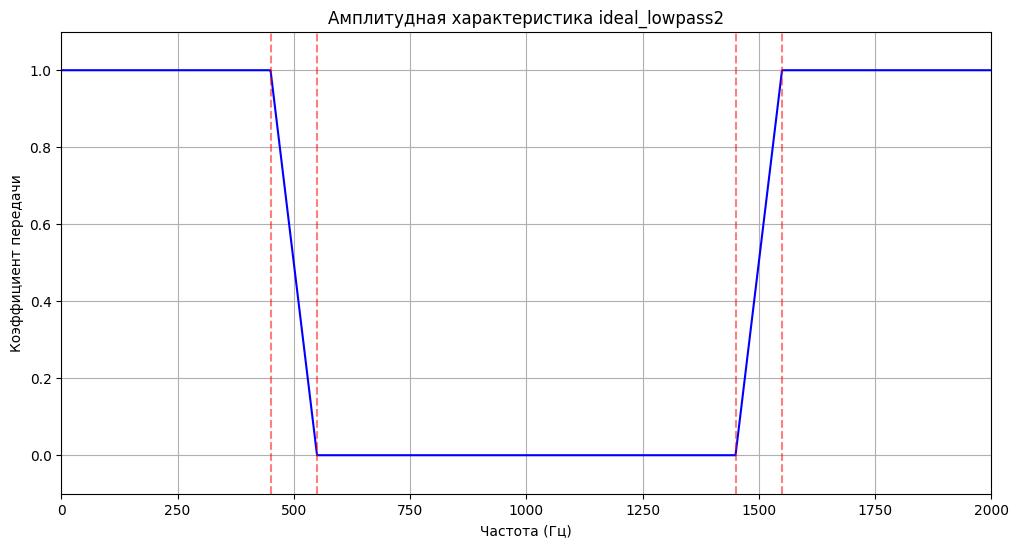

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def ideal_lowpass2(f, f_c=450, fs=2000):
    f1 = 450
    f2 = 550
    if 0 <= f <= f1 or fs - f1 <= f <= fs:
        return 1.0 + 0.0j
    elif f1 < f < f2:
        return (f / (f1 - f2)) + (f2 / (f2 - f1)) + 0.0j
    elif fs - f2 < f < fs - f1:
        return (f / (f2 - f1)) + ((fs - f2) / (-f2 + f1)) + 0.0j
    else:
        return 0.0 + 0.0j

# Генерация частот и значений
f_values = np.linspace(0, 2000, 2000)
H = np.array([ideal_lowpass2(f) for f in f_values])

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(f_values, np.real(H), color='b')
plt.title('Амплитудная характеристика ideal_lowpass2')
plt.xlabel('Частота (Гц)')
plt.ylabel('Коэффициент передачи')
plt.grid(True)
plt.axvline(450, color='r', linestyle='--', alpha=0.5)
plt.axvline(550, color='r', linestyle='--', alpha=0.5)
plt.axvline(1450, color='r', linestyle='--', alpha=0.5)
plt.axvline(1550, color='r', linestyle='--', alpha=0.5)
plt.xlim(0, 2000)
plt.ylim(-0.1, 1.1)
plt.show()


###  Несимметричная $h[k]$

In [10]:
def ideal_lowpass(f, f_c=450, fs=2000):
    if 0 <= f <= f_c or fs-f_c <= f <=  fs:
        return 1.0 +0.0j
    else:
        return 0.0 +0.0j


In [11]:
N=25
fs=2000
H=np.zeros(N, dtype=complex)
for n in range(N):
    H[n]=ideal_lowpass(f=fs*n/N)


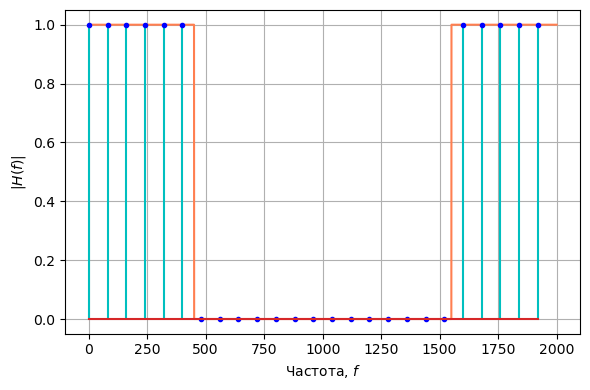

In [12]:
f_band=np.linspace(0, 2000, 10240)
plt.figure(figsize=[6, 4])
plt.plot(f_band, [abs(ideal_lowpass(f)) for f in f_band], color='coral')
plt.stem(fs*np.arange(N)/N, abs(H), linefmt='c', markerfmt='b.')
plt.xlabel('Частота, $f$')
plt.ylabel('$|H(f)|$')
plt.tight_layout() 
plt.grid()


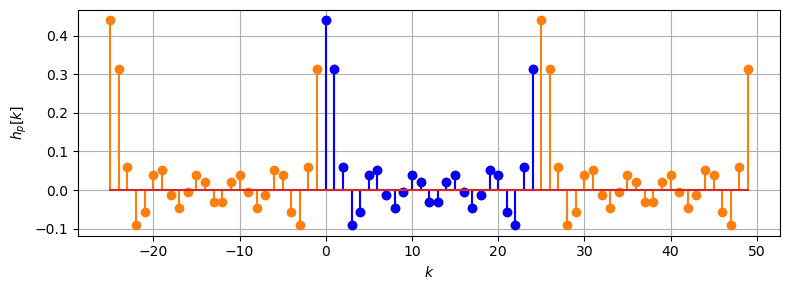

In [13]:
h=np.fft.ifft(H).real
h3=np.concatenate((h, h, h ))
plt.figure(figsize=[8, 3])
plt.stem(np.arange(3*N)-N, h3, linefmt='C1', markerfmt='C1o')
plt.stem(np.arange(N), h, linefmt='b', markerfmt='bo')
plt.xlabel('$k$')
plt.ylabel('$h_p[k]$')
plt.grid()
plt.tight_layout()


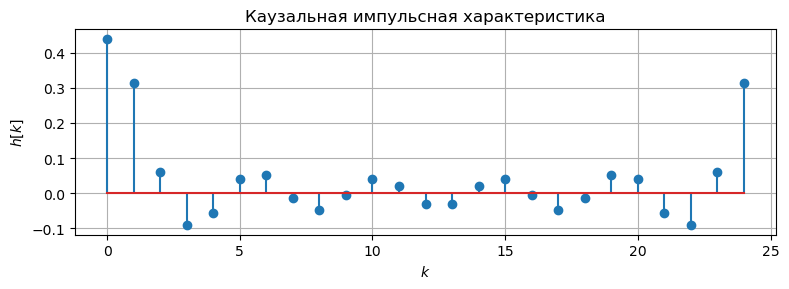

In [14]:
h=np.fft.ifft(H).real
M=1024
H1=abs(np.fft.fft(h, M))

plt.figure(figsize=[8, 3])
plt.stem(np.arange(N), h)
plt.xlabel('$k$')
plt.ylabel('$h[k]$')
plt.title("Каузальная импульсная характеристика")
plt.grid()
plt.tight_layout()


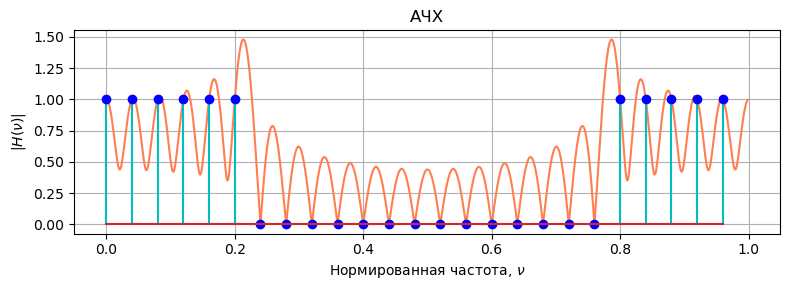

In [15]:
plt.figure(figsize=[8, 3])
plt.plot(np.arange(M)/M, H1, color='coral')
plt.stem(np.arange(N)/N, abs(np.fft.fft(h)), linefmt='c', markerfmt='bo')
plt.grid()
plt.ylabel('$|H(\\nu)|$')
plt.xlabel('Нормированная частота, $\\nu$')
plt.title('АЧХ')
plt.tight_layout()


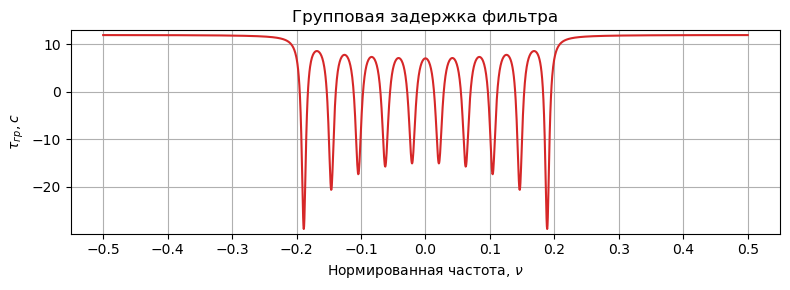

In [16]:
delta=1e-6
nu, gd = signal.group_delay((h, [1]), w=np.linspace(-0.5+delta, 0.5-delta, num=2048), fs=1)

plt.figure(figsize=[8, 3])
plt.title('Групповая задержка фильтра')
plt.plot(nu, gd*1, 'C3')
plt.ylabel('$\\tau_{{гр}}, c$')
plt.xlabel('Нормированная частота, $\\nu$')
plt.ylim([min(gd)-1, max(gd)+1])
plt.xticks(np.linspace(-0.5, 0.5, 11))
plt.grid()
plt.tight_layout()


### Симметричная $h[k]$ (учет ФЧХ идеального фильтра)

Синтезируем указанным методом фильтр первого типа с кусочно-линейной ФЧХ. 
В полосе пропускания $[-\nu_c, \nu_c]$ фазовую характеристику зададим равной $\varphi (\nu) = \exp \left( -j 2 \pi \nu \dfrac{N-1}{2}\right)$, а в полосе задержки в силу $H_{ideal}(\nu)=0$ значения фазы нам не важны. Выборки этой фазы 
$\varphi[n] = \varphi \left( \dfrac{n}{N} \right) = \exp \left( -j 2 \pi n \dfrac{N-1}{2N}\right)$.

In [17]:
N=25
fs=2000
H=np.zeros(N, dtype=complex)
alpha=(N-1.0)/2.0
for n in range(N):
    H[n]=ideal_lowpass(f=fs*n/N)*np.exp(-2j * np.pi * (N-1)/2.0 * n / N)


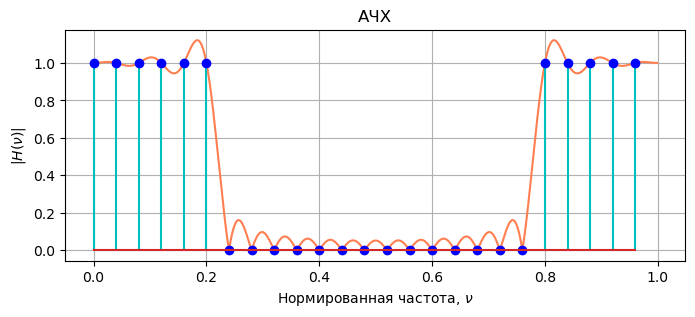

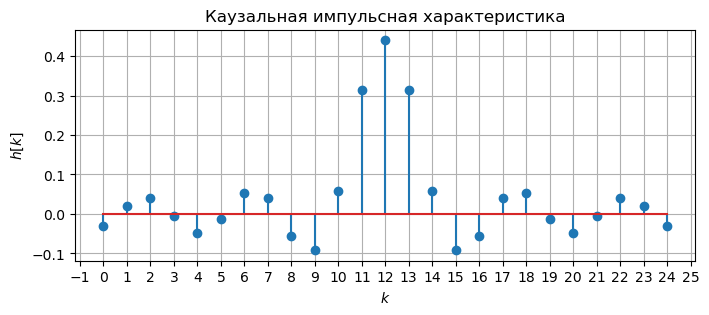

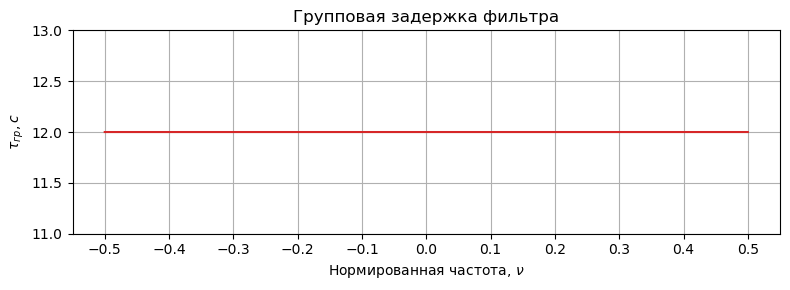

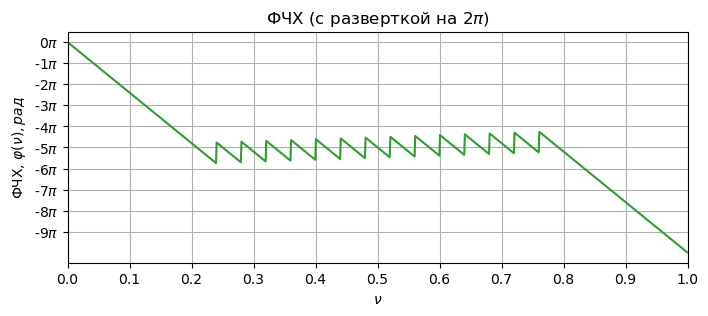

In [18]:
h=np.fft.ifft(H).real
M=1024
H1=abs(np.fft.fft(h, M))

plt.figure(figsize=[8, 3])
plt.plot(np.arange(M)/M, H1, color='coral')
plt.stem(np.arange(N)/N, abs(np.fft.fft(h)), linefmt='c', markerfmt='bo')
plt.grid()
plt.ylabel('$|H(\\nu)|$')
plt.xlabel('Нормированная частота, $\\nu$')
plt.title('АЧХ')

plt.figure(figsize=[8, 3])
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
plt.stem(np.arange(N), h)
plt.xlabel('$k$')
plt.ylabel('$h[k]$')
plt.title("Каузальная импульсная характеристика")
plt.grid()

delta=1e-6
nu, gd = signal.group_delay((h, [1]), w=np.linspace(-0.5+delta, 0.5-delta, num=2048), fs=1)

plt.figure(figsize=[8, 3])
plt.title('Групповая задержка фильтра')
plt.plot(nu, gd*1, 'C3')
plt.ylabel('$\\tau_{{гр}}, c$')
plt.xlabel('Нормированная частота, $\\nu$')
plt.ylim([min(gd)-1, max(gd)+1])
plt.xticks(np.linspace(-0.5, 0.5, 11))
plt.grid()
plt.tight_layout()

plt.figure(figsize=[8, 3])
ax = plt.subplot(111)
H1=((np.fft.fft(h, M)))
plt.plot(np.arange(M)/M, np.unwrap(np.angle(H1)), color='C2')
plt.title("ФЧХ (с разверткой на $2\\pi$)")
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.1))
plt.xlim([0, 1])
#plt.yticks([-np.pi, 0, np.pi], labels=("$-\pi$", "0", "$\pi$"))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(base=np.pi))
plt.yticks(np.arange(0, min(np.unwrap(np.angle(H1))), -np.pi), labels=("%i$\\pi$" %u for u in range(0, -10, -1)))
plt.xlabel('$\\nu$')
plt.ylabel('ФЧХ, $\\varphi(\\nu), рад$')
plt.grid()


### Симметричная $h[k]$ (циклический сдвиг)

In [19]:
N=25
fs=2000
H=np.zeros(N, dtype=complex)
for n in range(N):
    H[n]=ideal_lowpass(f=fs*n/N)


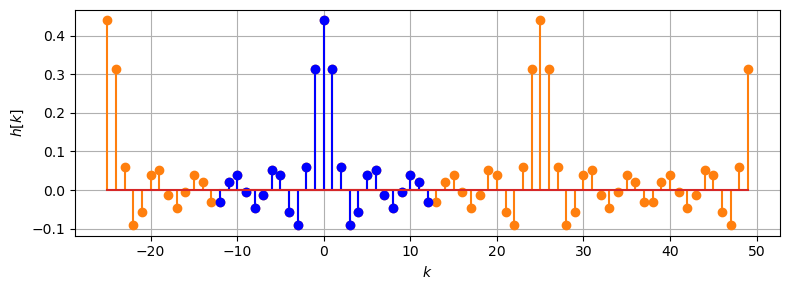

In [20]:
h=np.fft.ifft(H).real
h3=np.concatenate((h, h, h ))
plt.figure(figsize=[8, 3])
plt.stem(np.arange(3*N)-N, h3, linefmt='C1', markerfmt='C1o')
plt.stem(np.arange(N)-N//2, np.roll(h, N//2), linefmt='b', markerfmt='bo')
plt.xlabel('$k$')
plt.ylabel('$h[k]$')
plt.grid()
plt.tight_layout()


Заметим, что циклический сдвиг не поменяет модули отсчетов ДПФ. 

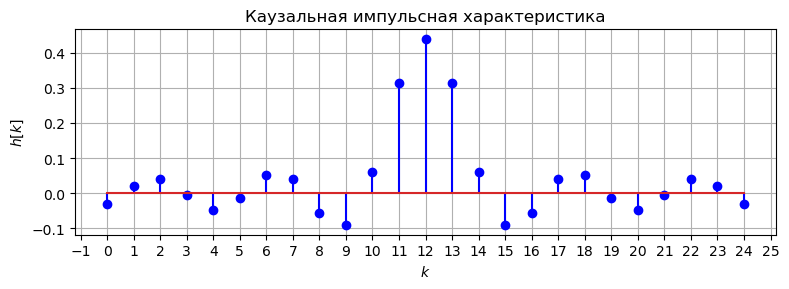

In [21]:
h=np.fft.ifft(H).real
h=np.roll(h, N//2)

plt.figure(figsize=[8, 3])
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
plt.stem(np.arange(N), h, linefmt='b', markerfmt='bo')
plt.xlabel('$k$')
plt.ylabel('$h[k]$')
plt.title("Каузальная импульсная характеристика")
plt.grid()
plt.tight_layout()


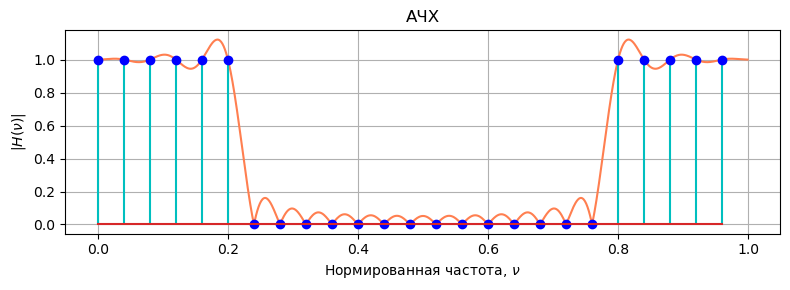

In [22]:
M=1024
H1=abs(np.fft.fft(h, M))

plt.figure(figsize=[8, 3])
plt.plot(np.arange(M)/M, H1, color='coral')
plt.stem(np.arange(N)/N, abs(np.fft.fft(h)), linefmt='c', markerfmt='bo')
plt.grid()
plt.ylabel('$|H(\\nu)|$')
plt.xlabel('Нормированная частота, $\\nu$')
plt.title('АЧХ')
plt.tight_layout()


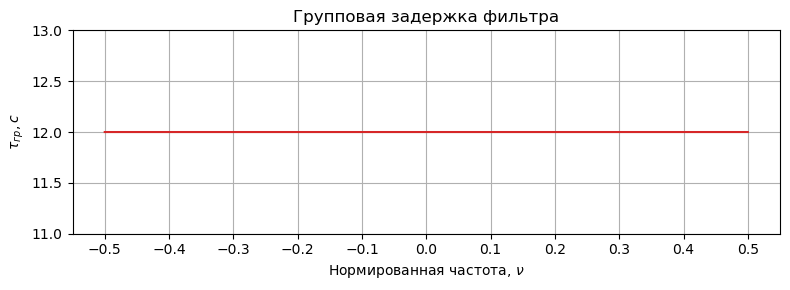

In [23]:
delta=1e-6
nu, gd = signal.group_delay((h, [1]), w=np.linspace(-0.5+delta, 0.5-delta, num=2048), fs=1)

plt.figure(figsize=[8, 3])
plt.title('Групповая задержка фильтра')
plt.plot(nu, gd*1, 'C3')
plt.ylabel('$\\tau_{{гр}}, c$')
plt.xlabel('Нормированная частота, $\\nu$')
plt.ylim([min(gd)-1, max(gd)+1])
plt.xticks(np.linspace(-0.5, 0.5, 11))
plt.grid()
plt.tight_layout()


### Выборки в полосе перехода

In [24]:
def ideal_lowpass2(f, f_c=450, fs=2000):
    f1=450
    f2=550
    if 0 <= f <= f1 or fs-f1 <= f <=  fs:
        return 1.0
    elif f1<f<f2: 
        return f/(f1-f2)+(f2/(f2-f1))
    elif fs-f2<f<fs-f1:
        return f/(f2-f1)+(fs-f2)/(-f2+f1)
    else:
        return 0.0 


In [25]:
N=25
fs=2000
H=np.zeros(N, dtype=complex)
for n in range(N):
    H[n]=ideal_lowpass2(f=fs*n/N)


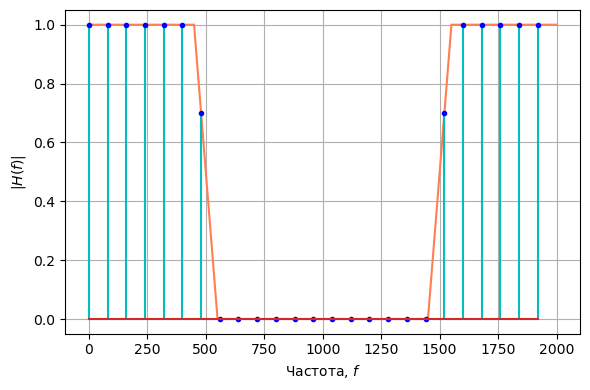

In [26]:
f_band=np.linspace(0, 2000, 10240)
plt.figure(figsize=[6, 4])
plt.plot(f_band, [abs(ideal_lowpass2(f)) for f in f_band], color='coral')
plt.stem(fs*np.arange(N)/N, abs(H), linefmt='c', markerfmt='b.')
plt.xlabel('Частота, $f$')
plt.ylabel('$|H(f)|$')
plt.tight_layout() 
plt.grid()


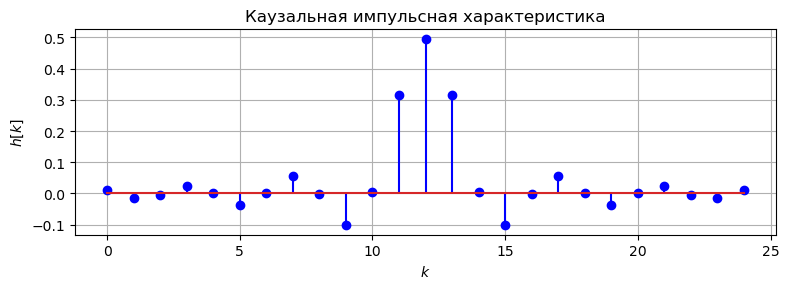

In [27]:
h=np.fft.ifft(H).real
h=np.roll(h, N//2)

plt.figure(figsize=[8, 3])
plt.stem(np.arange(N), h, linefmt='b', markerfmt='bo')
plt.xlabel('$k$')
plt.ylabel('$h[k]$')
plt.title("Каузальная импульсная характеристика")
plt.grid()
plt.tight_layout()


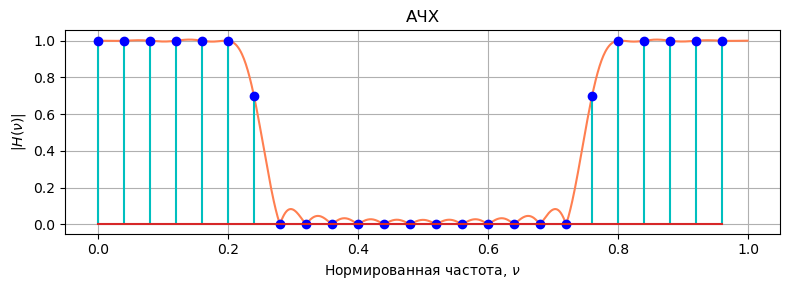

In [28]:
M=1024
H1=abs(np.fft.fft(h, M))

plt.figure(figsize=[8, 3])
plt.plot(np.arange(M)/M, H1, color='coral')
plt.stem(np.arange(N)/N, abs(np.fft.fft(h)), linefmt='c', markerfmt='bo')
plt.grid()
plt.ylabel('$|H(\\nu)|$')
plt.xlabel('Нормированная частота, $\\nu$')
plt.title('АЧХ')
plt.tight_layout()


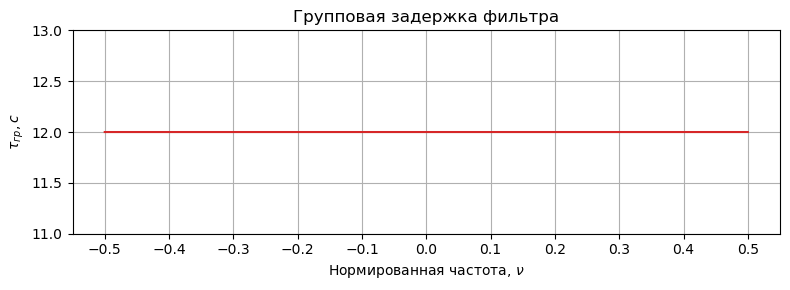

In [29]:
delta=1e-6
nu, gd = signal.group_delay((h, [1]), w=np.linspace(-0.5+delta, 0.5-delta, num=2048), fs=1)

plt.figure(figsize=[8, 3])
plt.plot(nu, gd*1, 'C3')
plt.ylabel('$\\tau_{{гр}}, c$')
plt.title('Групповая задержка фильтра')
plt.xlabel('Нормированная частота, $\\nu$')
plt.ylim([min(gd)-1, max(gd)+1])
plt.xticks(np.linspace(-0.5, 0.5, 11))
plt.grid()
plt.tight_layout()


* Повторить для $N=35$ (для двух отсчетов в полосе пропускания)

## Литература
* [1] В.П. Васильев и др. Основы теории и расчета цифровых фильтров. Москва, ИНФРА-М, 2020
* [2] А. И. Солонина Цифровая обработка сигналов в зеркале MATLAB: учеб. пособие. — СПб.: БХВ-Петербург, 2021.
* [3] Якимов Е.В. Цифровая обработка сигналов. Учебное пособие. - 2-е изд. - Томск, Издательство Томского политехнического университета, 2011. 
* [4] Л.Рабинер, Б.Гоулд. Теория и применение цифровой обработки сигналов, М.:Мир, 1978
